## 1.  Imports

In [1]:
import itertools, json, math, os, sys, warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_log_error
from sklearn.preprocessing import StandardScaler
from scipy.optimize import minimize

## 2. Load Data

In [2]:
print("Reading train / test")
train = pd.read_csv("/kaggle/input/playground-series-s5e5/train.csv")
test  = pd.read_csv("/kaggle/input/playground-series-s5e5/test.csv")
y_true = train["Calories"].values
ids    = test["id"].values

ver_meta = {
    "v1": {"oof"     : "/kaggle/input/calorie-prediction-oof-predictions/oof_predictions_pg_s5e5v1.csv",
           "sub_dir" : "/kaggle/input/calorie-prediction-oof-predictions",
           "sub_fmt" : "sub_{model}_v1.csv"},
    "v2": {"oof"     : "/kaggle/input/calorie-prediction-oof-predictions/oof_predictions_pg_s5e5v2.csv",
           "sub_dir" : "/kaggle/input/calorie-prediction-oof-predictions",
           "sub_fmt" : "sub_{model}_v2.csv"},
    "v3": {"oof"     : "/kaggle/input/calorie-prediction-oof-predictions/oof_predictions_pg_s5e5v3.csv",
           "sub_dir" : "/kaggle/input/calorie-prediction-oof-predictions",
           "sub_fmt" : "sub_{model}_v3.csv"},
    #  v4 files are just sub_<Model>.csv (no “_v4” suffix)
    "v4": {"oof"     : "/kaggle/input/57-02-feature-engineering/oof_predictions_pg_s5e5.csv",
           "sub_dir" : "/kaggle/input/57-02-feature-engineering/subs",
           "sub_fmt" : "sub_{model}.csv"},
}

def load_version(tag):
    meta   = ver_meta[tag]
    oof_df = pd.read_csv(meta["oof"]).set_index("id")
    model_cols = [c for c in oof_df.columns if c != "Calories"]

    pred_test = {}
    for m in model_cols:
        # build expected filename and read it
        sub_fp = Path(meta["sub_dir"]) / meta["sub_fmt"].format(model=m)
        pred_test[m] = pd.read_csv(sub_fp).set_index("id")["Calories"]
    test_df = pd.DataFrame(pred_test)

    print(f" • {tag}: {len(oof_df):,} rows | {len(model_cols)} models")
    return oof_df[model_cols], test_df[model_cols]

versions = {tag: load_version(tag) for tag in ver_meta}

Reading train / test
 • v1: 750,000 rows | 7 models
 • v2: 750,000 rows | 7 models
 • v3: 750,000 rows | 7 models
 • v4: 750,000 rows | 3 models


## 3. Define RMSLE Metric

In [3]:
def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, np.clip(y_pred, 0, None)))

## 4. Published Scores

In [4]:
cv_score = {
    # ── Version-1 (“no extra features”) ──
    "Ridge"      : 0.5648,
    "Lasso"      : 0.3475,
    "ElasticNet" : 0.4903,
    "HistGBR"    : 0.0635,
    "XGBoost"    : 0.060810,
    "LightGBM"   : 0.061795,
    "CatBoost"   : 0.0619,

    # ── Version-2 (“+4 features”) ──
    "Ridge_v2"      : 0.5301,
    "Lasso_v2"      : 0.3603,
    "ElasticNet_v2" : 0.4397,
    "HistGBR_v2"    : 0.0636,
    "XGBoost_v2"    : 0.0608,
    "LightGBM_v2"   : 0.0620,
    "CatBoost_v2"   : 0.0618,

    # ── Version-3 (“+20 features”) ──
    "Ridge_v3"      : 0.1639,
    "Lasso_v3"      : 0.1520,
    "ElasticNet_v3" : 0.1632,
    "HistGBR_v3"    : 0.0626,
    "XGBoost_v3"    : 0.0606,
    "LightGBM_v3"   : 0.0614,
    "CatBoost_v3"   : 0.0628,

    # ── Version-4 (“+140 features”; only 3 models) ──
    "XGBoost_v4"  : 0.0609,
    "LightGBM_v4" : 0.0615,
    "CatBoost_v4" : 0.0626,
}

lb_scores = {
    # V1
    "Ridge"      : 0.57370,
    "Lasso"      : 0.34456,
    "ElasticNet" : 0.48845,
    "HistGBR"    : 0.06264,
    "XGBoost"    : 0.05938,
    "LightGBM"   : 0.05976,
    "CatBoost"   : 0.06014,

    # V2  (only those you have – others omitted → equal weight)
    "HistGBR_v2"  : 0.06131,
    "XGBoost_v2"  : 0.05887,
    "LightGBM_v2" : 0.06018,
    "CatBoost_v2" : 0.05999,

    # V3
    "Ridge_v3"      : 0.16165,
    "Lasso_v3"      : 0.14929,
    "ElasticNet_v3" : 0.16090,
    "HistGBR_v3"    : 0.06193,
    "XGBoost_v3"    : 0.05881,
    "LightGBM_v3"   : 0.05968,
    "CatBoost_v3"   : 0.06080,

    # V4
    "XGBoost_v4"  : 0.05918,
    "LightGBM_v4" : 0.05958,
    "CatBoost_v4" : 0.06043,
}

## 5. Enumerate all version-combos and prepare

In [5]:
combos = []
for r in range(1, len(versions)+1):
    for take in itertools.combinations(versions.keys(), r):
        tag = "+".join(take)
        oof  = pd.concat([versions[t][0] for t in take], axis=1)
        test = pd.concat([versions[t][1] for t in take], axis=1)
        combos.append((tag, oof, test))
print(f"\nTotal combos generated: {len(combos)}")


Total combos generated: 15


## 6.  Ensemble helpers

In [6]:
def inv_lb_weights(cols, tag):
    w = np.ones(len(cols))
    for i,c in enumerate(cols):
        model = c.split("_")[0] if "_" in c else c
        for v in tag.split("+"):
            sc = lb_scores.get(v,{}).get(model)
            if sc: w[i] = 1.0 / sc
    return w / w.sum()

def ridge_blend(Xoof,Xtst,y):
    scaler = StandardScaler()
    Xs = scaler.fit_transform(Xoof); Xt = scaler.transform(Xtst)
    mdl = Ridge(alpha=1.0, random_state=42).fit(Xs,y)
    return mdl.predict(Xs), mdl.predict(Xt)

def hill_climb(Xoof,y,iters=2000):
    best=1e9; best_w=None; X=Xoof.values
    for _ in range(iters):
        w=np.random.dirichlet(np.ones(X.shape[1]))
        s=rmsle(y,X@w)
        if s<best: best=s; best_w=w
    return best_w

def opt_slsqp(Xoof,y):
    d=Xoof.shape[1]
    f=lambda w:rmsle(y,Xoof.values@w)
    con=({'type':'eq','fun':lambda w:1-w.sum()})
    res=minimize(f,np.full(d,1/d),method='SLSQP',bounds=[(0,1)]*d,constraints=con)
    return res.x

## 7. Blend Builder

In [7]:
results, preds = {}, {}
for tag,oof_df,test_df in tqdm(combos,desc="Combos"):
    cols = oof_df.columns
    Xoof = oof_df.values; Xtst = test_df.values

    # simple mean
    p_o = Xoof.mean(1); p_t = Xtst.mean(1)
    results[(tag,"mean")] = rmsle(y_true,p_o); preds[(tag,"mean")] = p_t

    # inverse-LB weighted mean
    w = inv_lb_weights(cols,tag)
    p_o=(Xoof*w).sum(1); p_t=(Xtst*w).sum(1)
    results[(tag,"wmean")] = rmsle(y_true,p_o); preds[(tag,"wmean")] = p_t

    # rank average
    p_o = oof_df.rank(axis=1).mean(1); p_t = test_df.rank(axis=1).mean(1)
    scale_o = oof_df.max(1).mean(); scale_t = test_df.max(1).mean()
    results[(tag,"rank")] = rmsle(y_true,p_o/p_o.max()*scale_o)
    preds[(tag,"rank")]  = p_t/p_t.max()*scale_t

    # ridge blend
    p_o,p_t = ridge_blend(oof_df,test_df,y_true)
    results[(tag,"ridge")] = rmsle(y_true,p_o); preds[(tag,"ridge")] = p_t

    # hill-climb
    w = hill_climb(oof_df,y_true)
    results[(tag,"hill")] = rmsle(y_true,Xoof@w); preds[(tag,"hill")] = Xtst@w

    # SLSQP optimal
    w = opt_slsqp(oof_df,y_true)
    results[(tag,"opt")]  = rmsle(y_true,Xoof@w); preds[(tag,"opt")]  = Xtst@w

Combos: 100%|██████████| 15/15 [09:57<00:00, 39.80s/it]


## 8. Comparison

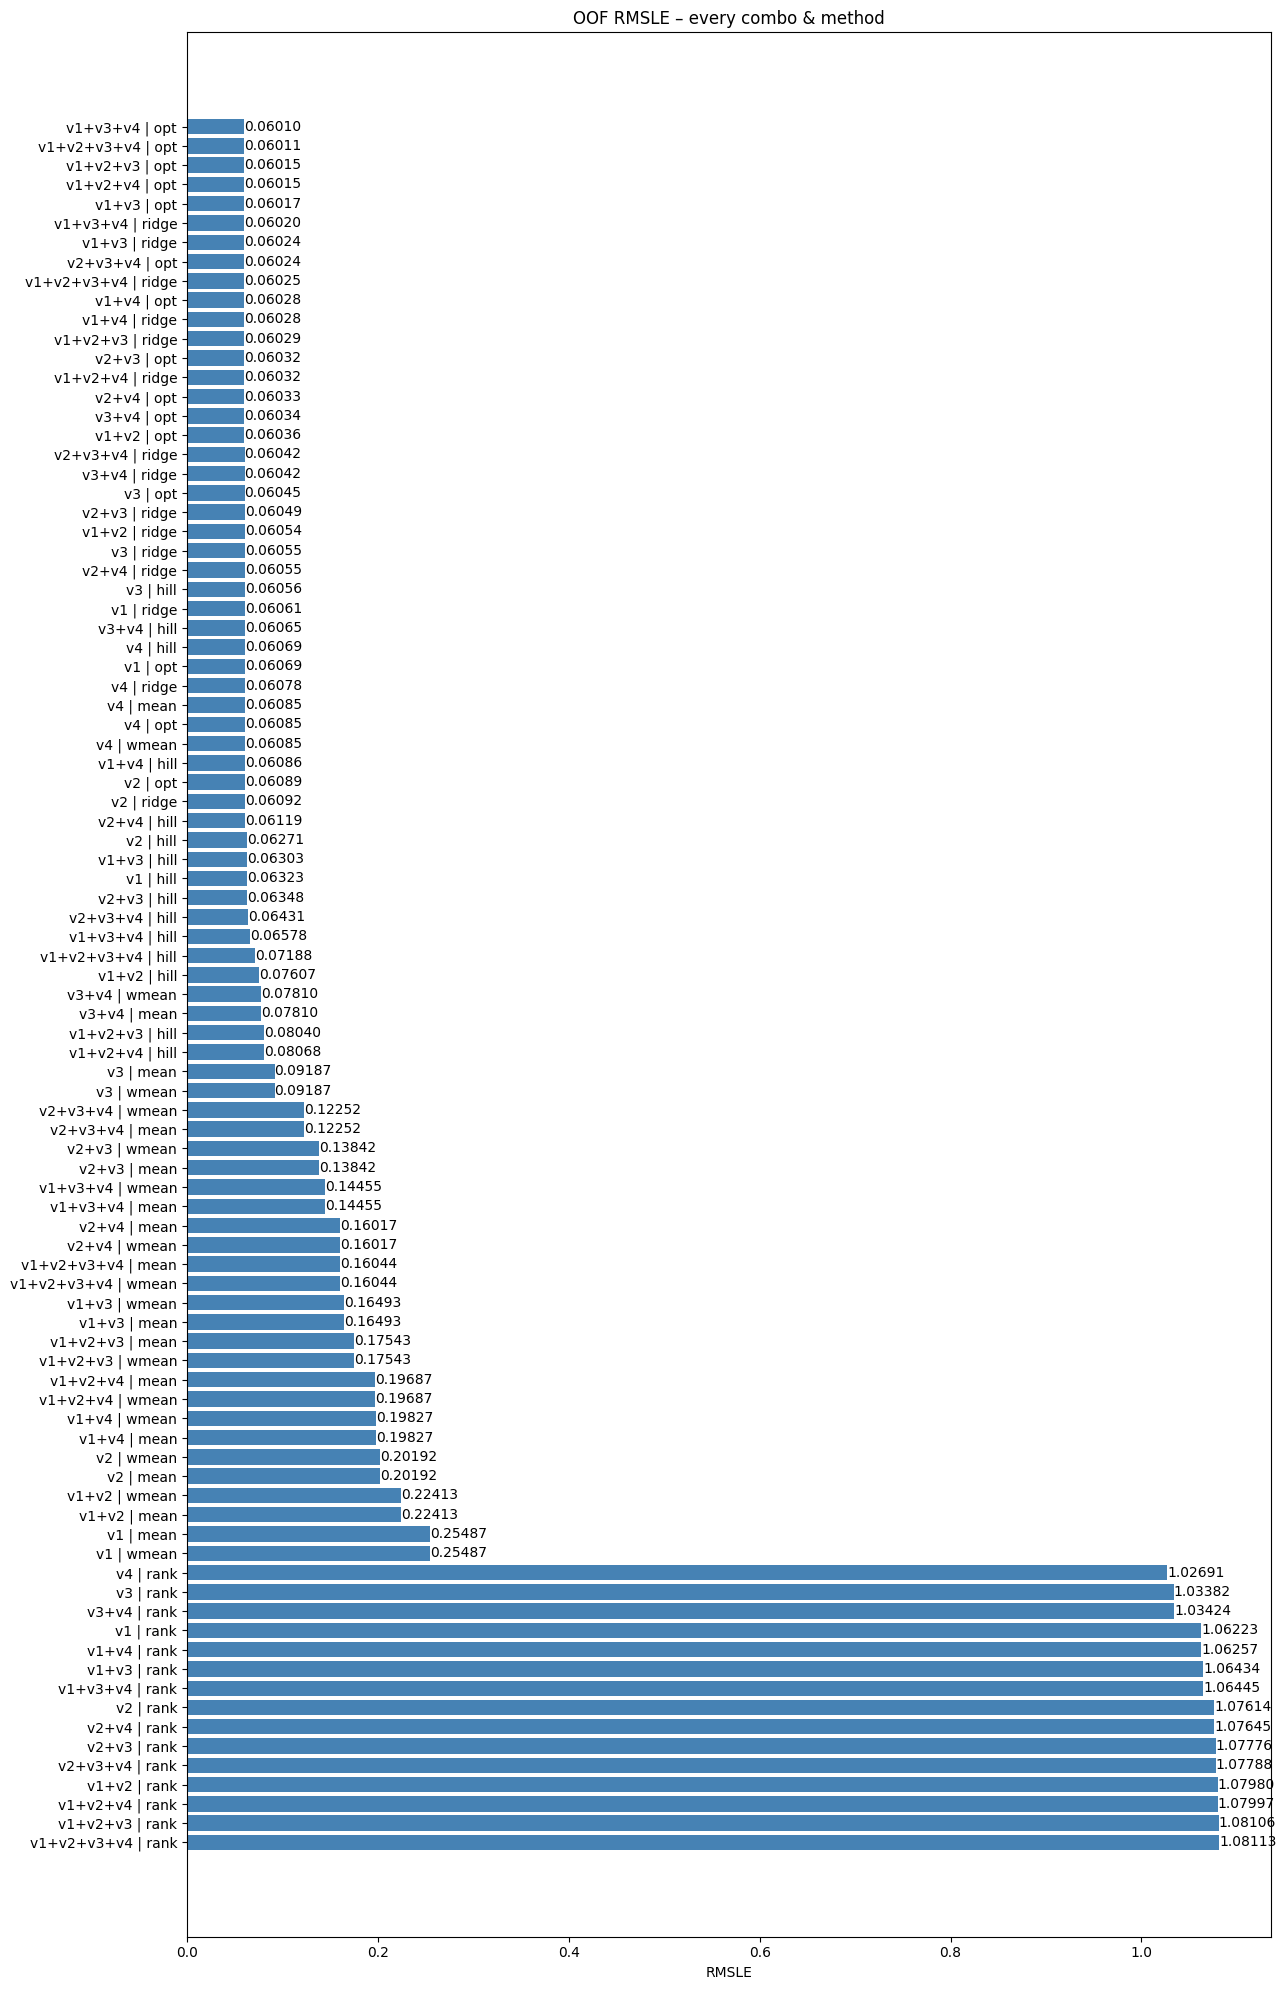

In [8]:
res_df = (pd.Series(results,name="RMSLE")
            .sort_values()
            .reset_index()
            .rename(columns={"level_0":"Combo","level_1":"Method"}))
plt.figure(figsize=(13,20))
plt.barh(res_df.index, res_df["RMSLE"],color="steelblue")
plt.yticks(res_df.index,[f"{c} | {m}" for c,m in res_df[["Combo","Method"]].values])
plt.gca().invert_yaxis()
plt.title("OOF RMSLE – every combo & method")
plt.xlabel("RMSLE")
for i,v in enumerate(res_df["RMSLE"]):
    plt.text(v+0.00005,i,f"{v:.5f}",va="center")
plt.tight_layout(); plt.show()

## 9. Submission

In [9]:
Path("submissions").mkdir(exist_ok=True)
for (combo,method),vec in preds.items():
    fn = f"submissions/sub_{combo.replace('+','_')}_{method}.csv"
    pd.DataFrame({"id": ids, "Calories": vec}).to_csv(fn,index=False)
    print(f"Wrote {fn}  ({len(vec):,} rows)")

Wrote submissions/sub_v1_mean.csv  (250,000 rows)
Wrote submissions/sub_v1_wmean.csv  (250,000 rows)
Wrote submissions/sub_v1_rank.csv  (250,000 rows)
Wrote submissions/sub_v1_ridge.csv  (250,000 rows)
Wrote submissions/sub_v1_hill.csv  (250,000 rows)
Wrote submissions/sub_v1_opt.csv  (250,000 rows)
Wrote submissions/sub_v2_mean.csv  (250,000 rows)
Wrote submissions/sub_v2_wmean.csv  (250,000 rows)
Wrote submissions/sub_v2_rank.csv  (250,000 rows)
Wrote submissions/sub_v2_ridge.csv  (250,000 rows)
Wrote submissions/sub_v2_hill.csv  (250,000 rows)
Wrote submissions/sub_v2_opt.csv  (250,000 rows)
Wrote submissions/sub_v3_mean.csv  (250,000 rows)
Wrote submissions/sub_v3_wmean.csv  (250,000 rows)
Wrote submissions/sub_v3_rank.csv  (250,000 rows)
Wrote submissions/sub_v3_ridge.csv  (250,000 rows)
Wrote submissions/sub_v3_hill.csv  (250,000 rows)
Wrote submissions/sub_v3_opt.csv  (250,000 rows)
Wrote submissions/sub_v4_mean.csv  (250,000 rows)
Wrote submissions/sub_v4_wmean.csv  (250,000 ro